In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [ ]:
budget_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal_logs/evaluation/helios_waiting_budget.log')

('constant', 1)
('linear_cost_filter_cpu', 1)
0.0
0.02
0.04
0.06
0.08
0.12
0.16
0.32
0.64
1.28
2.56
5.12
10.24
20.48
40.96
81.92
163.84
327.68
655.36
['Constant-Wait', 'Starburst']


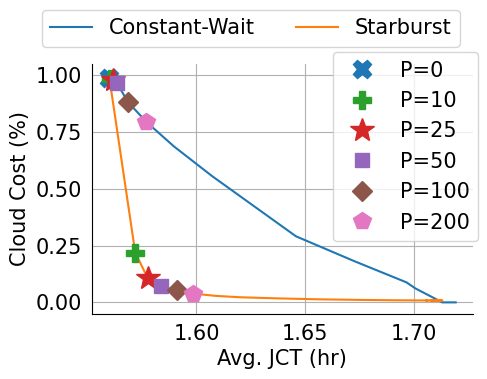

In [225]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant + OO',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        print(label)
        marker = next(markers)
        if label == ('constant', 0):
            continue
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
        
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        for row in grp.iterrows():
            row = row[1]
            temp=False
            if row['waiting_policy_x'] == 'constant':
                if row['waiting_factor_x'] == 0:
                    marker = 'X'
                    color = 'tab:blue'
                    marker_size = 13
                    temp=True
                elif row['waiting_factor_x'] == 0.2:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.4:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.8:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 1.6:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 3.2:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_cost_filter_cpu':
                if row['waiting_factor_x'] == 0.02:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.04:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.08:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.16:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.32:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
                print(row['waiting_factor_x'])
            
            if temp:
                plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)

        # Helios
        # 0.25 - constant wait - 0.4
        # 0.25 - compute wait - 0.04
    
    from matplotlib.lines import Line2D
    plt.legend([Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='P=0'),
             Line2D([0], [0], marker='P', color='w', markerfacecolor='tab:green', \
             markersize=13, markeredgecolor='tab:green', label='Constant-Wait'),
              Line2D([0], [0], marker='*', color='w', markerfacecolor='tab:red', \
             markersize=18, markeredgecolor='tab:red', label='Starburst'),
             Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:purple', \
             markersize=10, markeredgecolor='tab:purple', label='Constant-Wait + No-SJ'),
              Line2D([0], [0], marker='D', color='w', markerfacecolor='tab:brown', \
             markersize=10, markeredgecolor='tab:brown', label='Constant-Wait + No-SJ'),
             Line2D([0], [0], marker='p', color='w', markerfacecolor='tab:pink', \
             markersize=13, markeredgecolor='tab:pink', label='Constant-Wait + No-SJ')
               ], ['P=0', 'P=10', 'P=25', 'P=50', 'P=100', 'P=200'], ncol=1,loc='lower right', bbox_to_anchor=(1.04, 0.25))



    for ax in axs:
        set_plotting_setting(ax)
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_budget.pdf', bbox_inches='tight')
    plt.show()

simulator_plotting_fn(budget_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)

In [221]:
philly_budget_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal_logs/evaluation/philly_waiting_budget.log')

('constant', 1)
('linear_cost', 1)
0.0
0.02
0.04
0.06
0.08
0.12
0.16
0.32
0.64
1.28
2.56
5.12
10.24
20.48
40.96
81.92
163.84
327.68
655.36
['Constant-Wait', 'Starburst']


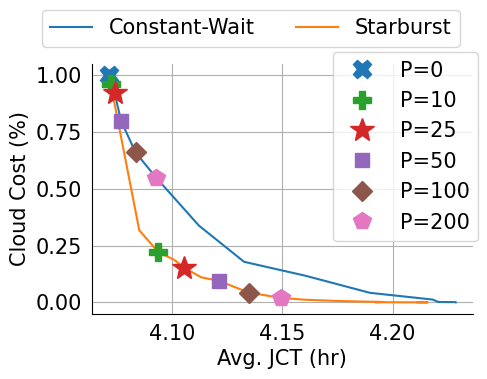

In [224]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant + OO',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        print(label)
        marker = next(markers)
        if label == ('constant', 0):
            continue
        if label[0] == 'constant':
            label = 'Constant-Wait'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, legend=None)
        
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        for row in grp.iterrows():
            row = row[1]
            temp=False
            if row['waiting_policy_x'] == 'constant':
                if row['waiting_factor_x'] == 0:
                    marker = 'X'
                    color = 'tab:blue'
                    marker_size = 13
                    temp=True
                elif row['waiting_factor_x'] == 0.4:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 1:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 2:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 4:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 8:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
            elif row['waiting_policy_x'] == 'linear_cost':
                if row['waiting_factor_x'] == 0.04:
                    color = 'tab:green'
                    temp=True
                    marker = 'P'
                    marker_size = 13
                elif row['waiting_factor_x'] == 0.08:
                    color = 'tab:red'
                    temp=True
                    marker = '*'
                    marker_size = 18
                elif row['waiting_factor_x'] == 0.16:
                    color = 'tab:purple'
                    temp=True
                    marker = 's'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.32:
                    color = 'tab:brown'
                    temp=True
                    marker = 'D'
                    marker_size = 10
                elif row['waiting_factor_x'] == 0.64:
                    color = 'tab:pink'
                    temp=True
                    marker = 'p'
                    marker_size = 13
                print(row['waiting_factor_x'])
            
            if temp:
                plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)

        # Helios
        # 0.25 - constant wait - 0.4
        # 0.25 - compute wait - 0.04
    
    from matplotlib.lines import Line2D
    plt.legend([Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='P=0'),
             Line2D([0], [0], marker='P', color='w', markerfacecolor='tab:green', \
             markersize=13, markeredgecolor='tab:green', label='Constant-Wait'),
              Line2D([0], [0], marker='*', color='w', markerfacecolor='tab:red', \
             markersize=18, markeredgecolor='tab:red', label='Starburst'),
             Line2D([0], [0], marker='s', color='w', markerfacecolor='tab:purple', \
             markersize=10, markeredgecolor='tab:purple', label='Constant-Wait + No-SJ'),
              Line2D([0], [0], marker='D', color='w', markerfacecolor='tab:brown', \
             markersize=10, markeredgecolor='tab:brown', label='Constant-Wait + No-SJ'),
             Line2D([0], [0], marker='p', color='w', markerfacecolor='tab:pink', \
             markersize=13, markeredgecolor='tab:pink', label='Constant-Wait + No-SJ')
               ], ['P=0', 'P=10', 'P=25', 'P=50', 'P=100', 'P=200'], ncol=1,loc='lower right', bbox_to_anchor=(1.04, 0.25))



    for ax in axs:
        set_plotting_setting(ax)
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly_budget.pdf', bbox_inches='tight')
    plt.show()

simulator_plotting_fn(philly_budget_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy','loop'],
                      normalize_x_axis=True)

In [12]:
from skyburst import job_generator

helios = job_generator.load_processed_jobs({'dataset': 'philly'})

In [14]:
print(np.percentile([j.runtime for j in helios if j.num_gpus > 0], 80))
print(np.percentile([j.runtime for j in helios if j.num_gpus > 0], 99))
print(np.max([j.num_gpus for j in helios]))
print(np.mean([j.runtime for j in helios if j.num_gpus >= 0]))


# get fraction of jobs that are above 15 mminutes (0.25)
print(len([j for j in helios if j.runtime > 15/60.0])/len(helios))


1.3055555555555556
79.80192777777764
128
4.059257746002732
0.5465521802919884


In [19]:
total_resource_capacity = np.mean([j.num_gpus + 0.02*j.num_cpus for j in helios])
total_gpu_capacity = np.mean([j.num_gpus for j in helios if j.num_gpus > 0])

print("Mean running time:", np.mean([j.runtime for j in helios]))
print("Mean running time with only gpu:", np.mean([j.runtime for j in helios if j.num_gpus>0]))


waiting_budget = 0.25

print('Without CPU jobs:')
print('-----------------')
cum_waiting_budget = 0.25 * sum([j.runtime for j in helios if j.num_gpus > 0])
#Compute Wait
mean_gpu_capacity = np.sum([(j.num_gpus+0.02 * j.num_cpus)*j.runtime for j in helios if j.num_gpus >0])
print('Compute-Wait:', cum_waiting_budget/mean_gpu_capacity)

# Constant Wait
print('Constant-Wait', np.mean([j.runtime for j in helios if j.num_gpus > 0])*0.25)


# Runtime Wait
print('Runtime-Wait', cum_waiting_budget/np.sum([j.runtime for j in helios if j.num_gpus>0]))

# Resource Wait
print('Resource-Wait', cum_waiting_budget/np.sum([j.num_gpus + 0.02 * j.num_cpus for j in helios if j.num_gpus>0]))

print('With CPU jobs:')
print('-----------------')
cum_waiting_budget = 0.25 * sum([j.runtime for j in helios])
#Compute Wait
mean_gpu_capacity = np.sum([(j.num_gpus + 0.02 * j.num_cpus)*j.runtime for j in helios])
print('Compute-Wait:', cum_waiting_budget/mean_gpu_capacity)

# Constant Wait
print('Constant-Wait', np.mean([j.runtime for j in helios])*0.25)


# Runtime Wait
print('Runtime-Wait', cum_waiting_budget/np.sum([j.runtime for j in helios]))

# Resource Wait
print('Resource-Wait', cum_waiting_budget/np.sum([j.num_gpus + 0.02 * j.num_cpus for j in helios]))


# Helios for P=25% waiting budget.
# A bit off from our derived formulas, but this is good enough. We assume that runtime and job size are uncorelated, leading to
# discrepancies.
# Without CPU jobs:
# -----------------
# Compute-Wait: 0.031120213814737376
# Constant-Wait 0.8747295256242429
# Runtime-Wait 0.2500000000000046
# Resource-Wait 0.17480595645840244
# With CPU jobs:
# -----------------
# Compute-Wait: 0.03577838884303312
# Constant-Wait 0.38926429377497623
# Runtime-Wait 0.25000000000012607
# Resource-Wait 0.20097148173465465

# Philly for P=25% waiting budget.
# Mean running time: 4.059257746002732
# Mean running time with only gpu: 4.059446281820004
# Without CPU jobs:
# -----------------
# Compute-Wait: 0.07299812211786463
# Constant-Wait 1.014861570455001
# Runtime-Wait 0.2500000000000015
# Resource-Wait 0.7679808844497075
# With CPU jobs:
# -----------------
# Compute-Wait: 0.07299824328533273
# Constant-Wait 1.014814436500683
# Runtime-Wait 0.2500000000000015
# Resource-Wait 0.7679821591989288

Mean running time: 4.059257746002732
Mean running time with only gpu: 4.059446281820004
Without CPU jobs:
-----------------
Compute-Wait: 0.07299812211786463
Constant-Wait 1.014861570455001
Runtime-Wait 0.2500000000000015
Resource-Wait 0.7679808844497075
With CPU jobs:
-----------------
Compute-Wait: 0.07299824328533273
Constant-Wait 1.014814436500683
Runtime-Wait 0.2500000000000015
Resource-Wait 0.7679821591989288


In [20]:

philly_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal1_logs/evaluation/philly_test.log')

In [21]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('constant', -1): 'Constant-Wait',
    ('constant', 0.25): 'Constant-Wait + No-SJ',
    'linear_runtime': 'Runtime',
    ('linear_cost', -1): 'Starburst',
    ('linear_capacity', -1): 'Starburst (Approx.)',
    ('zero', -1): 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    ('linear_cost_filter_cpu', -1): 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (Approx.)': 'tab:purple'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
#         if 2.5*(baseline_cost - cost) > 100000:
#             print(row['cluster_size'], row['cost_mult'], row['system_utilization_x'])
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, color=color, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    # fig.legend(lines, labels, bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')

    fig.legend([lines[4], lines[3], lines[0], lines[1], lines[2]], [labels[4], labels[3], labels[0], labels[1], labels[2]], ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    for row in diff_df.iterrows():
        row = row[1]
        if row['waiting_policy_x'] == 'linear_cost':
            print(row['cluster_size'], row['norm_system_utilization'], row['cost_mult'], row['cost_diff'], row['avg_jct_x'], row['cluster_utilization_x'])
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly.pdf', bbox_inches='tight')
    plt.show()  

16 3.5287648484368552 2.4763741683610174 45966.26666669996 4.26814263884152 0.9923404426815019
20 2.823011878749484 3.016953495217223 52611.340277805575 4.260646006257738 0.989195788224288
24 2.3525098989579036 5.215503234310004 85763.06180557556 4.245360679865526 0.9894579680167688
28 2.0164370562496314 6.625036092933801 101950.90763890941 4.235818070550457 0.9862281693507537
32 1.7643824242184276 7.012929336220708 99795.85486111522 4.208533685219461 0.9823737499978896
36 1.5683399326386023 9.237214561867024 121589.31736110972 4.184170223680418 0.977447461403935
40 1.411505939374742 10.466693528382498 126821.2888888923 4.171335533790613 0.9762033933142742
44 1.2831872176134018 13.484971846402438 149839.68958332538 4.139610837552034 0.9686809685863965
48 1.1762549494789518 15.577194986019837 155456.181944438 4.122546813356832 0.9622906937178196
52 1.0857737995190324 20.267408565738755 183774.74166666376 4.0752707168949796 0.9611821686419364
56 1.0082185281248157 23.998135447485215 1939

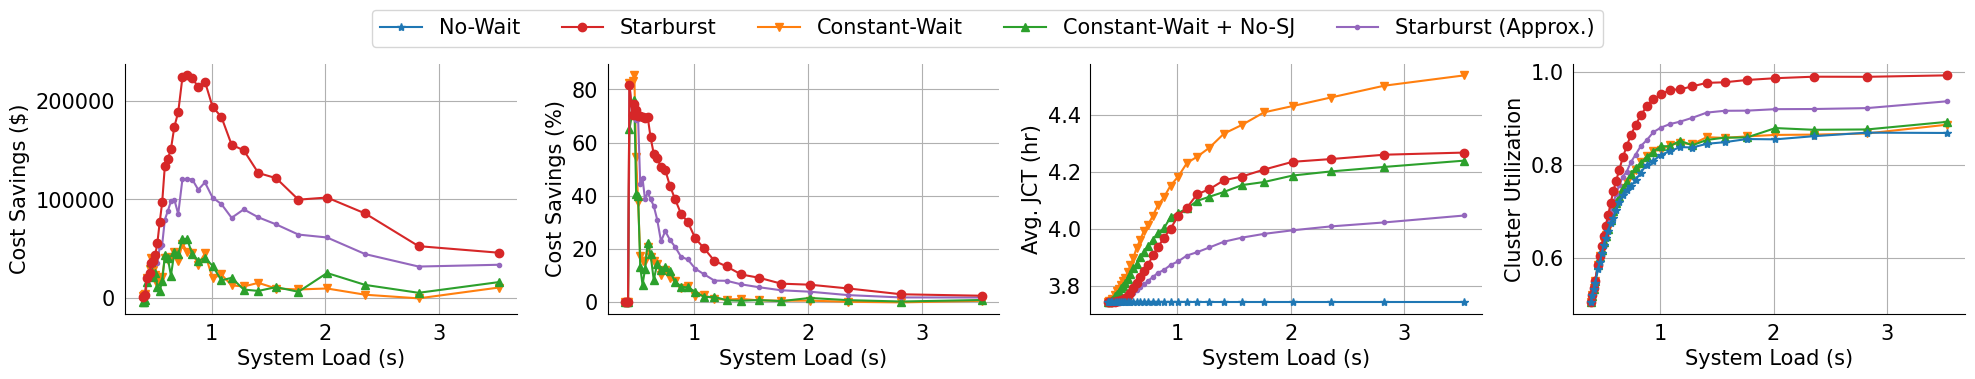

In [22]:

simulator_plotting_fn(philly_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero', 'long_job_thres': -1, 'loop': 0},
                      groupby_values=['waiting_policy', 'long_job_thres'],
                      normalize_x_axis=True)

In [7]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('constant', -1): 'Constant-Wait',
    ('constant', 0.25): 'Constant-Wait + No-SJ',
    ('linear_cost', -1): 'Starburst',
    ('zero', -1): 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    ('linear_cost_filter_cpu', -1): 'Starburst',
    ('linear_capacity_filter_cpu',-1): 'Starburst (approx.)',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (approx.)': 'tab:purple',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
#         if 2.5*(baseline_cost - cost) > 100000:
#             print(row['cluster_size'], row['cost_mult'], row['system_utilization_x'])
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        print(label)
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, color=color, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    # fig.legend(lines, labels, bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')

    fig.legend([lines[4], lines[3], lines[0], lines[1], lines[2]], [labels[4], labels[3], labels[0], labels[1], labels[2]], ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    for row in diff_df.iterrows():
        row = row[1]
        if row['waiting_policy_x'] == 'linear_cost':
            print(row['cluster_size'], row['norm_system_utilization'], row['cost_mult'], row['cost_diff'], row['avg_jct_x'], row['cluster_utilization_x'])
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios.pdf', bbox_inches='tight')
    plt.show()  

In [8]:

helios_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal1_logs/evaluation/helios.log')

('constant', -1.0)
('constant', 0.25)
('linear_capacity_filter_cpu', -1.0)
('linear_cost_filter_cpu', -1.0)
('zero', -1.0)


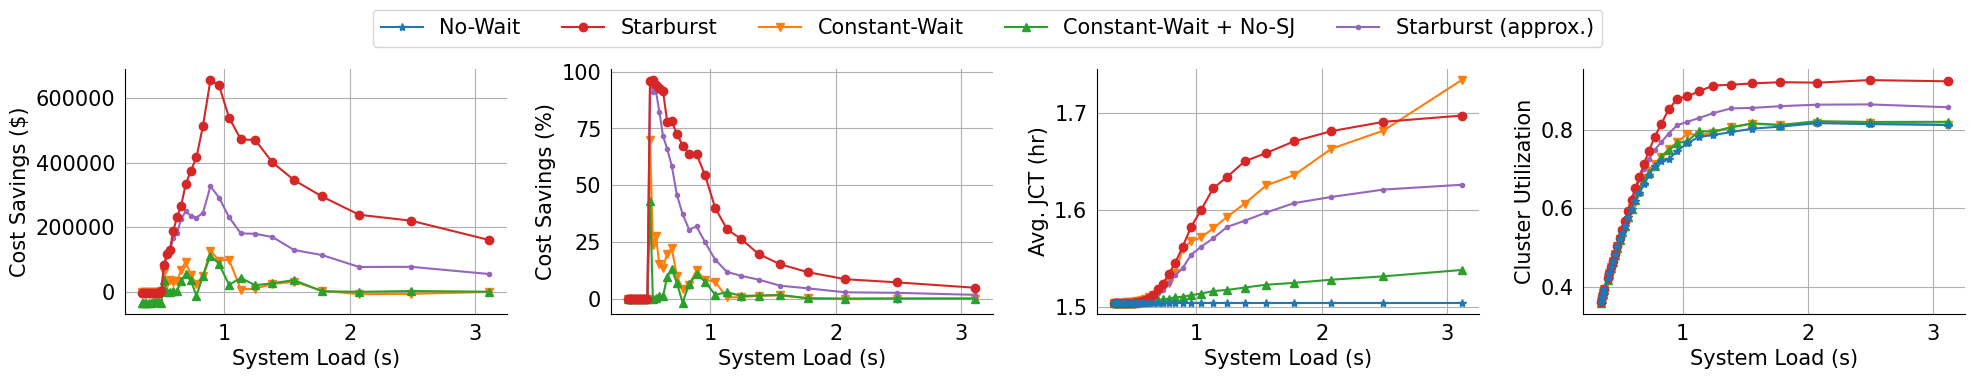

In [9]:

simulator_plotting_fn(helios_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero', 'long_job_thres': -1, 'loop': 0},
                      groupby_values=['waiting_policy', 'long_job_thres'],
                      normalize_x_axis=True)

In [123]:
# Pareto curves
philly_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal_logs/evaluation/philly_pareto.log')

('constant', -1.0)
Constant-Wait
('constant', 0.25)
Constant-Wait + No-SJ
Constant-Wait + No-SJ
('linear_cost', -1.0)
Starburst
0      0.876938
1      0.876938
2      0.876938
3      0.876938
4      0.876927
         ...   
97     0.876033
98     0.876043
99     0.876043
100    0.875949
101    0.875949
Name: system_utilization_x, Length: 102, dtype: float64
['Constant-Wait', 'Constant-Wait + No-SJ', 'Starburst', 'No-Wait']


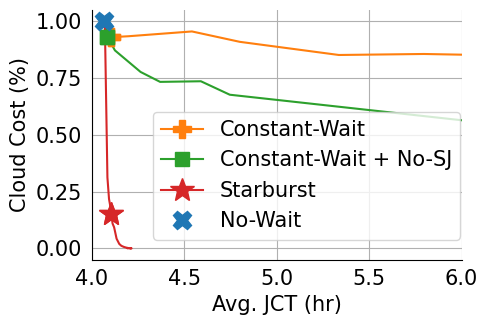

In [149]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=4, right=6)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        print(label)
        if label[0] == 'constant':
            if float(label[1]) == 0.25:
                label  = 'Constant-Wait + No-SJ'
                print(label)
                color='tab:green'
            else:
                label = 'Constant-Wait'
                color='tab:orange'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
            color= 'tab:red'
        else:
            continue
        print(label)
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    print(diff_df['system_utilization_x'])
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== -1:
            color = 'tab:orange'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== 0.25:
            color = 'tab:green'
            temp=True
            marker = 's'
            marker_size = 10
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08:
            color = 'tab:red'
            temp=True
            marker = '*'
            marker_size = 18
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(4.065, 1, marker="X", markersize=13, markeredgecolor='tab:blue', markerfacecolor='tab:blue', label='No-Wait')
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='Constant-Wait'), \
            Line2D([0], [0], marker='s', color='tab:green', markerfacecolor='tab:green', \
            markersize=10, markeredgecolor='tab:green', label='Constant-Wait + No-SJ'), \
             Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=18, markeredgecolor='tab:red', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.94, 0.25))
    
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/philly_pareto.pdf', bbox_inches='tight')
    plt.show()
    
    
simulator_plotting_fn(philly_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy', 'long_job_thres'],
                      normalize_x_axis=True)

In [2]:
# Pareto curves
helios_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal_logs/evaluation/helios_pareto.log')

('constant', -1.0)
Constant-Wait
('constant', 0.25)
Constant-Wait + No-SJ
Constant-Wait + No-SJ
('linear_cost_filter_cpu', -1.0)
Starburst
0      0.768998
1      0.768998
2      0.768998
3      0.768998
4      0.768995
         ...   
101    0.768742
102    0.768740
103    0.768740
104    0.768740
105    0.768740
Name: system_utilization_x, Length: 106, dtype: float64
['Constant-Wait', 'Constant-Wait + No-SJ', 'Starburst', 'No-Wait']


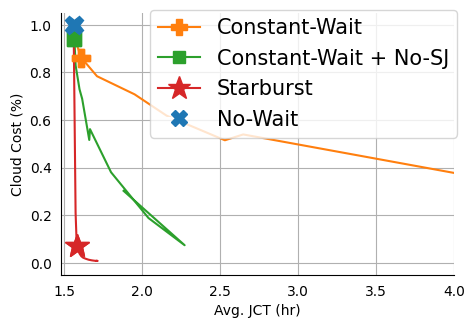

In [3]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            print(avg_job_volume_rate)
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
            print(diff_df['norm_system_utilization'])
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
#         elif baseline_cost <=10000:
#             # Small cloud cost for No wait
#             # Savings over small cloud cost is negligible for organizations.
#             return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
#     for row in diff_df.iterrows():
#         row = row[1]
#         if row['loop_x']==0:
#             continue
        #print(row['waiting_policy_x'], row['waiting_factor_x'], row['loop_x'], row['avg_jct_x'], row['norm_cloud_cost'], (row['avg_jct_x']-4)*5 + 0.3, row['norm_cloud_cost']*100/25)
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        print(label)
        if label[0] == 'constant':
            if float(label[1]) == 0.25:
                label  = 'Constant-Wait + No-SJ'
                print(label)
                color='tab:green'
            else:
                label = 'Constant-Wait'
                color='tab:orange'
        elif label[0] == 'linear_cost' or label[0] == 'linear_cost_filter_cpu':
            if label[1] == 0:
                continue
            label = 'Starburst'
            color= 'tab:red'
        else:
            continue
        print(label)
        #import pdb; pdb.set_trace()
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
#     lines, labels = ax.get_legend_handles_labels()
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    print(diff_df['system_utilization_x'])
#     fig.legend(lines, labels, ncol=1,loc='upper right', bbox_to_anchor=(0.96, 0.94))
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== -1:
            color = 'tab:orange'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== 0.25:
            color = 'tab:green'
            temp=True
            marker = 's'
            marker_size = 10
        elif row['waiting_policy_x'] == 'linear_cost_filter_cpu' and row['waiting_factor_x'] == 0.08:
            color = 'tab:red'
            temp=True
            marker = '*'
            marker_size = 18
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(1.56, 1, marker="X", markersize=13, markeredgecolor='tab:blue', markerfacecolor='tab:blue', label='No-Wait')
    
    lines, labels = ax.get_legend_handles_labels()
    print(labels)
#     fig.legend(lines, labels, ncol=len(labels), \
#                bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=12, markeredgecolor='tab:orange', label='Constant-Wait'), \
            Line2D([0], [0], marker='s', color='tab:green', markerfacecolor='tab:green', \
            markersize=9, markeredgecolor='tab:green', label='Constant-Wait + No-SJ'), \
             Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=17, markeredgecolor='tab:red', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=12, markeredgecolor='tab:blue', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.96, 0.55))
    
    
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_pareto.pdf', bbox_inches='tight')
    plt.show()
    
    
simulator_plotting_fn(helios_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy', 'long_job_thres'],
                      normalize_x_axis=True)

[<matplotlib.lines.Line2D object at 0x7faf08443880>, <matplotlib.lines.Line2D object at 0x7faf08443b50>, <matplotlib.lines.Line2D object at 0x7faf08443df0>, <matplotlib.lines.Line2D object at 0x7faf084530d0>, <matplotlib.lines.Line2D object at 0x7faf08453370>, <matplotlib.lines.Line2D object at 0x7faf08453610>, <matplotlib.lines.Line2D object at 0x7faf084538b0>]


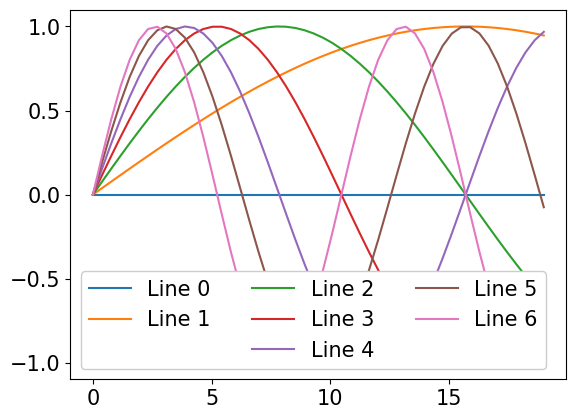

In [133]:
import matplotlib.pyplot as plt
import numpy as np

ncols = 3  # or 4
nlines = 7 # or 10

x = np.linspace(0,19)
f = lambda x,p: np.sin(x*p)
h = [plt.plot(x,f(x,i/10.), label="Line {}".format(i))[0] for i in range(nlines)]
print(h)
h.insert(nlines//ncols, plt.plot([],[],color=(0,0,0,0), label=" ")[0])
plt.legend(handles=h, ncol=ncols, framealpha=1)

plt.show()

In [151]:

helios_jct_df = utils.load_logs_as_dataframe('/home/gcpuser/rebuttal_logs/evaluation/helios_percentile.log')

In [166]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    #ax.set_xlim(right=2.75)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'avg_wait': 'Wait Time (hr)',
}

legend_dict = {
    'constant': 'Constant-Wait',
    ('constant', 0.25): 'Constant-Wait + No-SJ',
    'linear_runtime': 'Runtime',
    'linear_cost_filter_cpu': 'Starburst',
    'zero': 'No-Wait',
    ('linear_cost', -1): 'Starburst',
    ('zero', -1): 'No-Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU',
    ('linear_cost_filter_cpu', -1): 'Starburst',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:blue',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    if not isinstance(axs, list):
        axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
#         if 2.5*(baseline_cost - cost) > 100000:
#             print(row['cluster_size'], row['cost_mult'], row['system_utilization_x'])
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    print(mod_y_axis)
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label == 'zero':
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            # if ax_idx < 2 and label=='No-Wait':
            #     continue
            color = color_dict[label]
            print(mod_y_axis[ax_idx])
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, color=color, label = label, legend=None)
            plt.plot(grp[x_axis],  grp['90_wait_x'], color=color, linestyle=(0, (5, 1)), alpha=1.0, linewidth=3)
            plt.plot(grp[x_axis],  grp['99_wait_x'], color=color, linestyle='dotted', alpha=1.0, linewidth=3)
            plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['90_wait_x'], color=color, alpha=0.4)
            plt.fill_between(grp[x_axis], grp[ mod_y_axis[ax_idx]], grp['99_wait_x'], color=color, alpha=0.2)


# plt.fill_between(dates, p90_values, p99_values, color="salmon", alpha=0.4, label="99th Percentile")
    from matplotlib.lines import Line2D
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    fig.legend(lines + [Line2D([0], [0], color='black', linestyle=(0, (5, 1)), lw=2),
         Line2D([0], [0], color='black', linestyle='dotted', lw=2)], labels + ['90%', '99%'], bbox_to_anchor=(0, 1.0, 1.1, 0.2),  ncol=2,loc='upper center')
    plt.tight_layout()
    plt.savefig('figures/evaluation/helios_jct.pdf', bbox_inches='tight')
    #plt.savefig('figures/evaluation/helios_99.pdf', bbox_inches='tight')
    plt.show()  

['avg_wait_x']
avg_wait_x
avg_wait_x


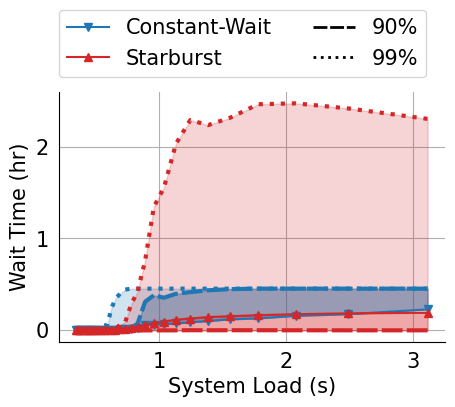

In [167]:
simulator_plotting_fn(helios_jct_df, x_axis='cluster_size',  \
                      y_axis=['avg_wait'], \
                      baseline_filter={'waiting_policy': 'zero', 'long_job_thres': -1, 'loop': 0},
                      groupby_values=['waiting_policy', ],
                      normalize_x_axis=True)